In [1]:
from lgca import get_lgca
import numpy as np
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# geometry
geom = 'hx'
restchannels = 1
l = 10
dims= l, l

In [4]:
# interaction parameters
r_m = 1e-3 # mutation rate for driver mutations
r_b = 0.1 # initial birth rate
r_d = 0.98 * r_b / 2 # initial death rate
capacity = 512 # deme capacity
gamma = 4. # rest channel weight
alpha = 2. # strength of steric interaction

In [5]:
nodes = np.zeros(dims+(6+restchannels,), dtype=int)
nodes[..., -1] = capacity

In [6]:
lgca = get_lgca(ib=True, bc='reflect', interaction='steric_evolution', dims=dims, nodes=nodes, ve=False, geometry='hx',
                r_m=r_m, r_b=r_b, capacity=capacity, gamma=gamma, r_d=r_d, alpha=alpha)

fitness increase for driver mutations set to  1.1


In [7]:
lgca.timeevo(1000, recordfampop=True, record=True)

100%|██████████| 1000/1000 [02:14<00:00,  7.46it/s]


(<Figure size 800x606.218 with 2 Axes>,
 <matplotlib.cm.ScalarMappable at 0x22052c1f550>)

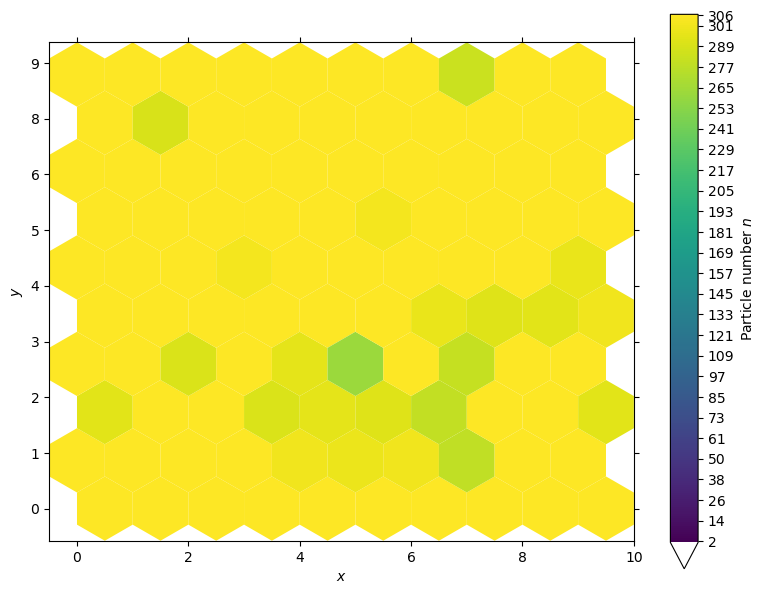

In [11]:
lgca.plot_density(lgca.dens_t[-1])

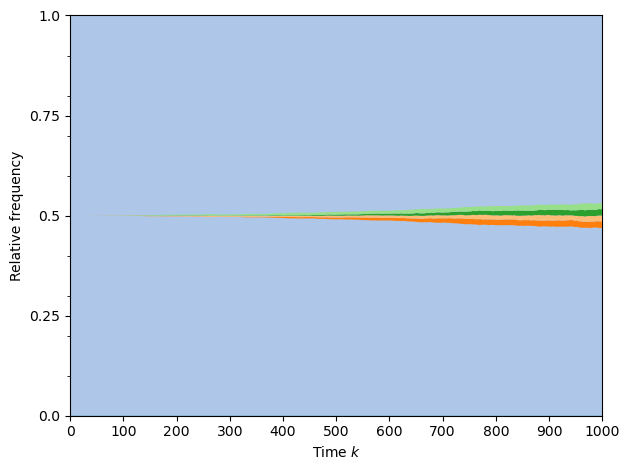

In [12]:
_, _, _, fcmap = lgca.muller_plot(cutoff_rel=0.01)

In [13]:
cells_t = lgca.nodes_t.sum(-1)

In [14]:
families_loc_t = np.zeros(cells_t.shape, dtype=int)
# families_loc_t[...] =np.nan

In [15]:
for ind, cells in np.ndenumerate(cells_t):
    if len(cells) == 0:
        continue
    else:
        values, counts = np.unique([lgca.props['family'][cell] for cell in cells], return_counts=True)
        ind2 = np.argmax(counts)
        families_loc_t[ind] = values[ind2]

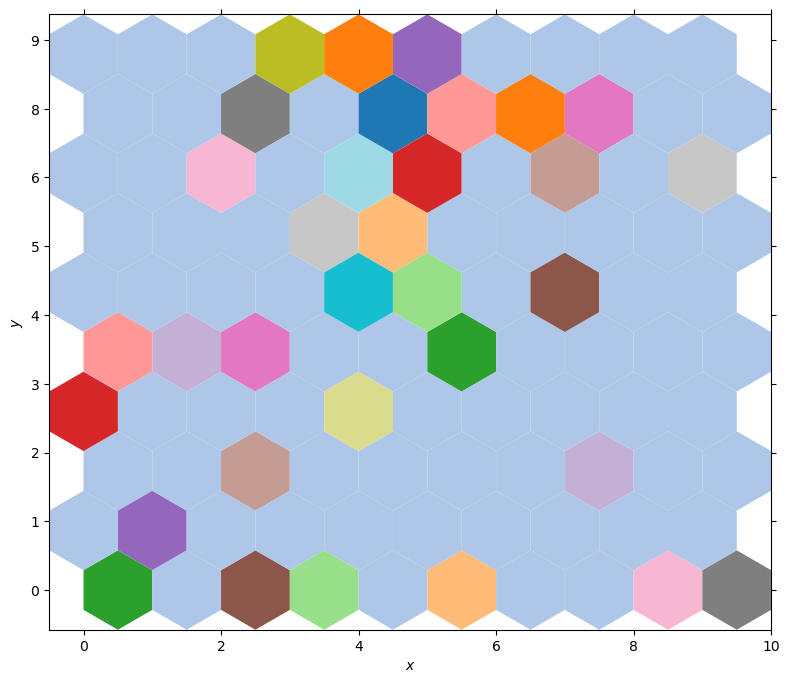

In [18]:
t = -1
# print(np.unique(families_loc_t[t]))
_, pc, _ = lgca.plot_scalarfield(families_loc_t[t], cmap='tab20', mask=1-np.heaviside(lgca.dens_t[t], 0), cbar=0)
pc.set_facecolor([fcmap(famid) for famid in families_loc_t[t].ravel()])

In [20]:
import networkx as nx

In [21]:
[*lgca.family_props]

['ancestor', 'descendants', 'r_b']

In [22]:
G = nx.Graph()
G.add_nodes_from(range(lgca.maxfamily))

In [23]:
G.add_edges_from([(i, j) for i in G.nodes for j in lgca.family_props['descendants'][i]])

In [59]:
fam_pop_t = lgca.filter_family_population_t(cutoff_rel=None)

In [60]:
fam_pop_t.shape, lgca.maxfamily

((1001, 1235), 1234)

In [61]:
# to do: colors like in Muller plot, adjust sizes (filter out families < cutoff? 1%?), calculate positions with some simple algorithm (generation along x, equally spaced along y

In [68]:
_, relevantfamids = np.unique(fam_pop_t, return_counts=0, return_index=1)

In [69]:
relevantfamids

array([    0,  3707, 18536, ...,  2471,  1236,     1], dtype=int64)

In [63]:
relevantfamilies = fam_pop_t
colors = [fcmap(famid) for famid in relevantfamids]
sizes = relevantfamilies[relevantfamids]/relevantfamilies.sum() * 4000

In [64]:
# for colors like in Muller plot: built a "color cycler", that cycles through all colors in tab20, then build a large list of colors and pick the right ones - use Biancas IdentityColourMapper!

In [65]:
len(colors), len(relevantfamilies), len(sizes)

(92, 1235, 92)

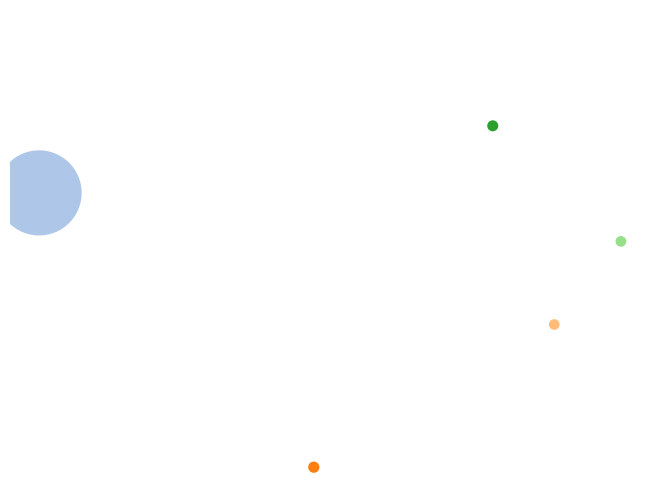

In [58]:
nx.draw(G, nodelist=relevantfamids, edgelist=[], node_size=sizes, linewidths=.01, node_color=colors)

In [134]:
import pickle 
with open('lgca_boundary_growthexample.lgca', 'wb') as file:
    pickle.dump(lgca, file)

In [135]:
with open('lgca_boundary_growthexample.lgca', 'rb') as file:
    # Call load method to deserialze
    lgca2 = pickle.load(file)

(<Figure size 800x606.218 with 2 Axes>,
 <matplotlib.cm.ScalarMappable at 0x25d2c660160>)

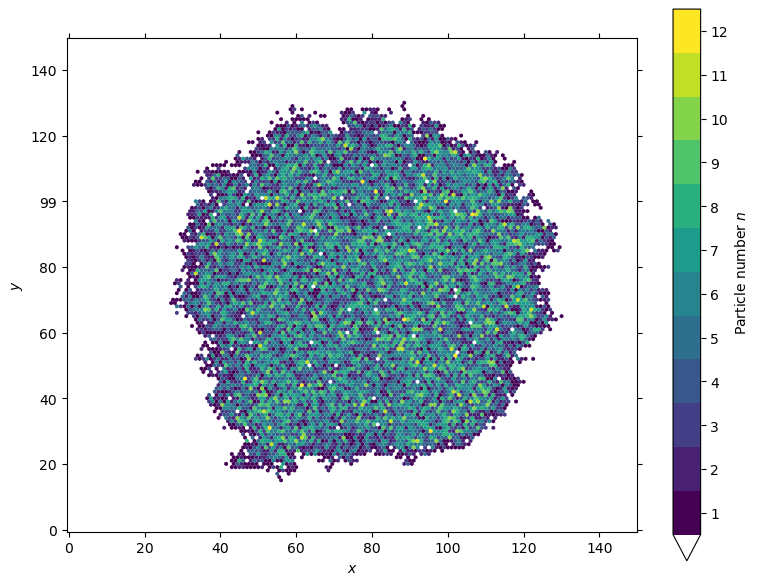

In [136]:
lgca2.plot_density()